In [ ]:
from tqdm.auto import tqdm

In [1]:
from dask.distributed import Client, LocalCluster
import dask.bag as db
import dask.dataframe as df

dask_client = Client(LocalCluster(
    n_workers=10,
    threads_per_worker=1))
dask_client

2022-07-25 10:02:50,771 - distributed.diskutils - INFO - Found stale lock file and directory '/home/eeisenst/workspace/compassionai/manas/notebooks/dask-worker-space/worker-2k7yzgah', purging
2022-07-25 10:02:50,771 - distributed.diskutils - INFO - Found stale lock file and directory '/home/eeisenst/workspace/compassionai/manas/notebooks/dask-worker-space/worker-9i_ic135', purging
2022-07-25 10:02:50,771 - distributed.diskutils - INFO - Found stale lock file and directory '/home/eeisenst/workspace/compassionai/manas/notebooks/dask-worker-space/worker-173g_4r2', purging
2022-07-25 10:02:50,771 - distributed.diskutils - INFO - Found stale lock file and directory '/home/eeisenst/workspace/compassionai/manas/notebooks/dask-worker-space/worker-kqcfloi4', purging
2022-07-25 10:02:50,771 - distributed.diskutils - INFO - Found stale lock file and directory '/home/eeisenst/workspace/compassionai/manas/notebooks/dask-worker-space/worker-ii6qb4l_', purging
2022-07-25 10:02:50,771 - distributed.di

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 10,Total memory: 31.17 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39909,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 31.17 GiB
Comm: tcp://127.0.0.1:38251,Total threads: 1
Dashboard: http://127.0.0.1:45785/status,Memory: 3.12 GiB
Nanny: tcp://127.0.0.1:34155,


# Load the dataset

In [2]:
import os
soas_dataset_path = os.path.join(os.environ['CAI_DATA_BASE_PATH'], "raw_datasets/SOAS-part-of-speech/Texts")
simplifiers_path = os.path.join(os.environ['CAI_DATA_BASE_PATH'], "raw_datasets/Esukhia-SOAS-pos-simplification")

In [3]:
tagged_words = df \
    .read_csv(os.path.join(soas_dataset_path, "*-horizontal.txt"), header=None, names=["folio"]) \
    .folio \
    .str.split(' ') \
    .explode()

In [4]:
pos_tags_df = df.from_array(tagged_words.str.split('|').values, columns=['tagged_word'])
pos_tags_df = pos_tags_df[pos_tags_df.tagged_word.map(len) == 2]
pos_tags_df.count().compute()

tagged_word    318230
dtype: int64

In [5]:
pos_tags_df['word'] = pos_tags_df.tagged_word.map(lambda x: x[0])
pos_tags_df['tag'] = pos_tags_df.tagged_word.map(lambda x: x[1])
del pos_tags_df['tagged_word']
pos_tags_df.head(10)

,word,tag
0,བདེ་བ,n.v.invar
1,ར་,case.term
2,གཤེགས་པ,n.v.invar
3,འི་,case.gen
4,བསྟན་བ,n.v.fut
5,འི་,case.gen
6,གསལ་བྱེད་ཆོས་,n.count
7,ཀྱི་,case.gen
8,འབྱུང་གནས་གསུང་རབ་,n.count
9,རིན་པོ་ཆེ,adj


## Transform the tags if needed

In [6]:
with open(os.path.join(simplifiers_path, "regex-SOAS-to-UD-BOD.txt"), 'r') as f:
    tag_mapping = f.read()
tag_mapping = eval(tag_mapping.replace('\n', '').replace(' ', ''))
tag_mapping = {left_tag: right_elem for left_elem, right_elem in tag_mapping for left_tag in left_elem.strip('(').strip(')').split('|')}
# tag_mapping

In [7]:
with open(os.path.join(simplifiers_path, "regex-UD-BOD-to-UD-ENG.txt"), 'r') as f:
    tag_remapping = f.read()
tag_remapping = eval(tag_remapping.replace('\n', '').replace(' ', ''))
tag_remapping = {left_tag: right_elem for left_elem, right_elem in tag_remapping for left_tag in left_elem.strip('(').strip(')').split('|')}
# tag_remapping

In [8]:
pos_tags_df["tag"] = pos_tags_df.tag.map(lambda tag: tag_mapping.get(tag, "unk"))
pos_tags_df["tag"] = pos_tags_df.tag.map(lambda tag: tag_remapping.get(tag, "unk"))

In [9]:
print("Fraction of unks:", len(pos_tags_df[pos_tags_df.tag == "unk"].compute()) / len(pos_tags_df.compute()))

Fraction of unks: 0.019727869779719073


# Tokenize

## Flatten sections

In [11]:
pos_tags_df = pos_tags_df.compute()

In [15]:
pos_tags_df.head(2)

,word,tag
0,བདེ་བ,NOUN
1,ར་,PART


In [49]:
tagged_sections = []

In [50]:
cur_section = []
for _, row in tqdm(pos_tags_df.iterrows(), total=len(pos_tags_df)):
    cur_section.append((row.word, row.tag))
    if row.tag == 'PUNCT':
        if not set([tag for _, tag in cur_section]) == {'PUNCT'}:
            tagged_sections.append(cur_section)
        cur_section = []

  0%|          | 0/318230 [00:00<?, ?it/s]

In [52]:
tagged_sections[0]

[('བདེ་བ', 'NOUN'),
 ('ར་', 'PART'),
 ('གཤེགས་པ', 'NOUN'),
 ('འི་', 'ADP'),
 ('བསྟན་བ', 'NOUN'),
 ('འི་', 'ADP'),
 ('གསལ་བྱེད་ཆོས་', 'NOUN'),
 ('ཀྱི་', 'ADP'),
 ('འབྱུང་གནས་གསུང་རབ་', 'NOUN'),
 ('རིན་པོ་ཆེ', 'ADJ'),
 ('འི་', 'ADP'),
 ('མཛོད་', 'NOUN'),
 ('ཅེས་', 'unk'),
 ('བྱ་བ', 'NOUN'),
 ('།', 'PUNCT')]

In [56]:
for c in tagged_sections[0][0][0]:
    print(c)

བ
ད
ེ
་
བ


## Tokenize

In [57]:
from cai_manas.tokenizer import CAITokenizerSlow
CAITokenizer = CAITokenizerSlow

In [73]:
tokenizer = CAITokenizer.from_pretrained(CAITokenizer.get_local_model_dir("olive-large"))

In [142]:
tagged_tokens = []
for cur_section in tqdm(tagged_sections):
    section_word = ''.join([word for word, _ in cur_section])
    section_tokens = tokenizer.encode(section_word)

    start_end, cur_idx = [], 0
    for word, _ in cur_section:
        start_end.append((cur_idx, cur_idx + len(word)))
        cur_idx += len(word)

    token_labels, word_start = [], 0
    for token_idx in range(1, len(section_tokens) + 1):
        word_so_far = tokenizer.decode(section_tokens[:token_idx])

        word_end = len(tokenizer.decode(section_tokens[:token_idx]))
        cur_labels = []
        for se_idx, cur_start_end in enumerate(start_end):
            if cur_start_end[0] < word_end and cur_start_end[1] > word_start:
                cur_labels.append(cur_section[se_idx][1])
            if cur_start_end[1] > word_start and cur_start_end[1] <= word_end:
                cur_labels.append('[WORD_END]')
        if cur_labels == []:
            cur_labels = ['[MASK]']
        token_labels.append((word_so_far[word_start:], '+'.join(sorted(list(set(map(lambda x: x.upper(), cur_labels)))))))
        word_start = word_end

    tagged_tokens.append((
        section_tokens,
        token_labels
    ))

  0%|          | 0/31309 [00:00<?, ?it/s]

In [143]:
i = 2
for word, tag in tagged_sections[i]:
    print(word, tag)
print("===")
for token, tag in zip(*tagged_tokens[i]):
    print(token, tag)

གང་ PART
ཞིག་ PART
ཐུགས་བསྐྱེད་དགེ་ཚོགས་བདུད་རྩི NOUN
འི་ ADP
ཟས་ཅན་ NOUN
ལས་ ADP
བྱུང་ VERB
བརྣག་དཀ NOUN
འི་ ADP
བཟོད་པ NOUN
ས་ ADP
གཟི་དཔལ་ NOUN
འབར་བ NOUN
། PUNCT
===
2 ('', '[MASK]')
463 ('གང་', 'PART+[WORD_END]')
677 ('ཞིག་', 'PART+[WORD_END]')
2239 ('ཐུགས་', 'NOUN')
1132 ('བསྐྱེད་', 'NOUN')
1300 ('དགེ་', 'NOUN')
323 ('ཚོགས་', 'NOUN')
1518 ('བདུད་', 'NOUN')
2696 ('རྩིའི་', 'ADP+NOUN+[WORD_END]')
5743 ('ཟས་ཅན་', 'NOUN+[WORD_END]')
4666 ('ལས་བྱུང་', 'ADP+VERB+[WORD_END]')
4525 ('བརྣ', 'NOUN')
11 ('ག་', 'NOUN')
179 ('དཀ', 'NOUN+[WORD_END]')
33 ('འི་', 'ADP+[WORD_END]')
2583 ('བཟོད་', 'NOUN')
634 ('པས་', 'ADP+NOUN+[WORD_END]')
6287 ('གཟི་', 'NOUN')
1248 ('དཔལ་', 'NOUN+[WORD_END]')
1359 ('འབར་', 'NOUN')
9878 ('བ', 'NOUN+[WORD_END]')
9955 ('།', 'PUNCT+[WORD_END]')
3 ('', '[MASK]')


## Explore

In [144]:
import pandas as pd

In [145]:
tagged_df = {
    "token": [],
    "text": [],
    "tag": []
}
for cur_tagged_tokens in tagged_tokens:
    for token, (text, tag) in zip(*cur_tagged_tokens):
        tagged_df["token"].append(token)
        tagged_df["text"].append(text)
        tagged_df["tag"].append(tag)
tagged_df = pd.DataFrame(tagged_df)

In [165]:
tagged_no_mask_df = tagged_df[tagged_df.tag != '[MASK]']

In [167]:
tagged_no_mask_df
# tagged_df

,token,text,tag
1,3193,བདེ་བར་,NOUN+PART+[WORD_END]
2,2394,གཤེགས་,NOUN
3,88,པའི་,ADP+NOUN+[WORD_END]
4,912,བསྟན་,NOUN
5,137,བའི་,ADP+NOUN+[WORD_END]
...,...,...,...
417979,9955,།,PUNCT+[WORD_END]
417982,3238,ཅེས་,UNK+[WORD_END]
417983,4263,གསུངས་,VERB+[WORD_END]
417984,319,ཤིང་,PART+[WORD_END]


In [171]:
tag_count_df = tagged_no_mask_df.groupby(tagged_no_mask_df.tag).count().token.sort_values()

<AxesSubplot:xlabel='tag'>

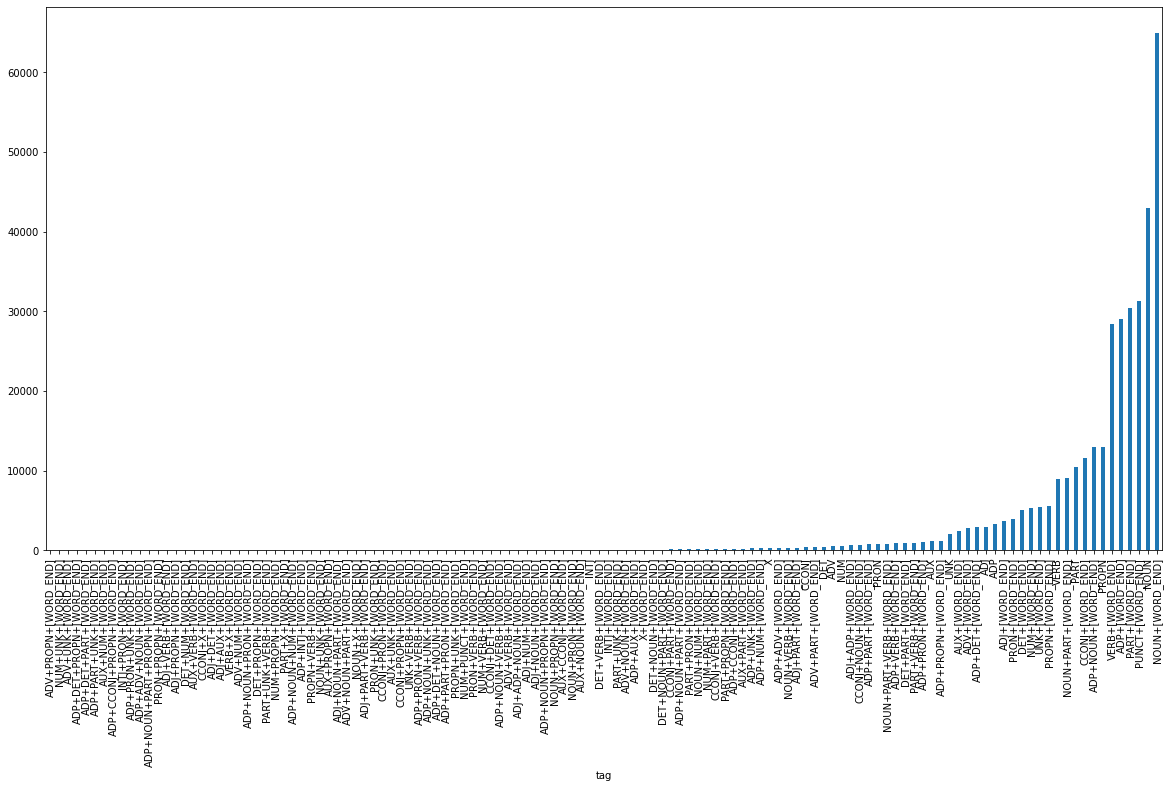

In [172]:
tag_count_df.plot(kind="bar", figsize=(20, 10))

## Filter rare tags

In [216]:
tag_rarity = 200

<AxesSubplot:xlabel='tag'>

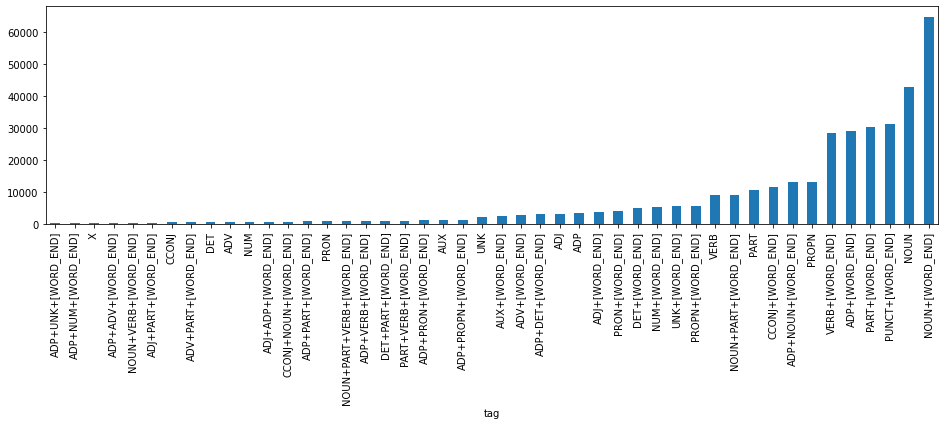

In [217]:
tag_count_df[tag_count_df > tag_rarity].plot(kind="bar", figsize=(16, 4))

In [218]:
print("Proposed new UNK rate:", tag_count_df[tag_count_df < tag_rarity].sum() / tag_count_df.sum())

Proposed new UNK rate: 0.006301042950655433


In [219]:
tags_to_remove = set(tag_count_df[tag_count_df < tag_rarity].index.tolist())
len(tags_to_remove)

77

In [220]:
filtered_tokens = []
for cur_tagged_tokens in tagged_tokens:
    cur_filtered_tokens = []
    for token, (word, tag) in zip(*cur_tagged_tokens):
        if tag in tags_to_remove:
            tag = 'UNK'
        cur_filtered_tokens.append((token, tag))
    filtered_tokens.append(cur_filtered_tokens)

In [221]:
print("Actual UNK rate:", sum([tag == 'UNK' for x in filtered_tokens for _, tag in x]) / sum([1 for x in filtered_tokens for _, tag in x]))

Actual UNK rate: 0.01023955290475541


# Save filtered_tokens

In [230]:
filtered_tokens[0]

[(2, '[MASK]'),
 (3193, 'NOUN+PART+[WORD_END]'),
 (2394, 'NOUN'),
 (88, 'ADP+NOUN+[WORD_END]'),
 (912, 'NOUN'),
 (137, 'ADP+NOUN+[WORD_END]'),
 (6569, 'NOUN'),
 (9012, 'ADP+NOUN+[WORD_END]'),
 (4512, 'NOUN'),
 (1828, 'NOUN'),
 (644, 'NOUN+[WORD_END]'),
 (1613, 'ADJ'),
 (5062, 'ADJ+ADP+[WORD_END]'),
 (1029, 'NOUN+[WORD_END]'),
 (6680, 'UNK+[WORD_END]'),
 (362, 'NOUN'),
 (9878, 'NOUN+[WORD_END]'),
 (9955, 'PUNCT+[WORD_END]'),
 (3, '[MASK]')]

In [231]:
final_dataset = [([t for t, _ in example], [l for _, l in example]) for example in filtered_tokens]

In [232]:
import os
import random
import pickle

In [233]:
test_frac = 0.1

In [234]:
train_data, test_data = [], []
for ex in final_dataset:
    if random.random() < test_frac:
        test_data.append(ex)
    else:
        train_data.append(ex)
len(train_data), len(test_data)

(28234, 3075)

In [235]:
dataset_dir = os.path.join(os.environ['CAI_DATA_BASE_PATH'], "processed_datasets/part-of-speech-olive/")

os.makedirs(dataset_dir, exist_ok=True)
with open(os.path.join(dataset_dir, "dataset.pkl"), 'wb') as f:
    pickle.dump(final_dataset, f)
with open(os.path.join(dataset_dir, "train.pkl"), 'wb') as f:
    pickle.dump(train_data, f)
with open(os.path.join(dataset_dir, "test.pkl"), 'wb') as f:
    pickle.dump(test_data, f)